In [2]:
import matplotlib.pyplot as plt
import numpy as np
from qtpyt.base.greenfunction import GreenFunction
from qtpyt.base.leads import LeadSelfEnergy
from qtpyt.parallel.egrid import GridDesc
from qtpyt.tools import expand_coupling
from scipy.linalg import eigh
from qtpyt.base.leads import SanchoRubio


In [3]:
def build_real_space_hamiltonian(half_natoms=20, ncells=50, onsite=0, first_neighbor_hopping=-2.7):

    # Logic implementation credits : Ozan Zeray

    H = np.zeros((2 * half_natoms, 2 * half_natoms))
    np.fill_diagonal(H, onsite)

    for i in range(half_natoms - 1):
        H[i, i + 1] = first_neighbor_hopping
        H[i + 1, i] = first_neighbor_hopping
        H[i + half_natoms, i + half_natoms + 1] = first_neighbor_hopping
        H[i + half_natoms + 1, i + half_natoms] = first_neighbor_hopping

    for i in range(half_natoms):
        if i % 2 == 0:
            H[i, i + half_natoms] = first_neighbor_hopping
            H[i + half_natoms, i] = first_neighbor_hopping

    H[0, half_natoms - 1] = first_neighbor_hopping
    H[half_natoms - 1, 0] = first_neighbor_hopping
    H[half_natoms, 2 * half_natoms - 1] = first_neighbor_hopping
    H[2 * half_natoms - 1, half_natoms] = first_neighbor_hopping
    T = np.zeros((2 * half_natoms, 2 * half_natoms))

    for i in np.arange(half_natoms, 2 * half_natoms):
        if i % 2 != 0:
            T[i - half_natoms, i] = first_neighbor_hopping

    I_Q = np.eye(ncells)
    S_up = np.diag(np.ones(ncells - 1), k=1)
    S_down = np.diag(np.ones(ncells - 1), k=-1)

    H_total = np.kron(I_Q, H) + np.kron(S_down, T) + np.kron(S_up, T.T)

    return H_total, T.T

def plot_gamma_eigenvalues(self_energy, energies, label="Left Lead", log=True):
    """
    Plot eigenvalues of the broadening matrix Γ(E) for a given self-energy over a range of energies.

    Parameters:
        self_energy : LeadSelfEnergy object
        energies : 1D array of energies (in eV)
        label : str, label for the plot
        log : bool, whether to use log scale for y-axis
    """
    gamma_eigvals = []

    for E in energies:
        sigma = self_energy.retarded(E)
        gamma = 1j * (sigma - sigma.T.conj())
        eigs = np.linalg.eigvalsh(gamma)
        gamma_eigvals.append(eigs)

    gamma_eigvals = np.array(gamma_eigvals)  # shape: (len(energies), N)

    plt.figure(figsize=(8, 5))
    for n in range(gamma_eigvals.shape[1]):
        plt.plot(energies, gamma_eigvals[:, n], lw=0.8, alpha=0.6)

    plt.xlabel("Energy (eV)")
    plt.ylabel("Eigenvalues of Γ(E)")
    plt.title(f"Broadening Eigenvalues (Γ) for {label}")
    if log:
        plt.yscale('log')
        plt.ylim(bottom=1e-8)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def compute_mode_count_from_bandstructure(H0, V, energies, nk=1000):
    """
    Count number of propagating modes at each energy based on sign changes in the band structure.

    Parameters:
        H0 : ndarray
            Intra-cell Hamiltonian.
        V : ndarray
            Inter-cell hopping matrix (should be transposed if needed).
        energies : ndarray
            Energies (eV) to evaluate mode count.
        nk : int
            Number of k-points for Brillouin zone sampling.

    Returns:
        mode_counts : ndarray
            Number of propagating modes per energy.

    Notes:
        - This function doesn't take into account band degeneracy. This may lead to double counting of modes.
    """
    N = H0.shape[0]
    kpts = np.linspace(-np.pi, np.pi, nk)
    bands = np.empty((nk, N))

    for i, k in enumerate(kpts):
        H_k = H0 + V * np.exp(-1j * k) + V.conj().T * np.exp(1j * k)
        eigvals = eigh(H_k, eigvals_only=True)
        bands[i] = np.sort(eigvals.real)

    mode_counts = []
    for E in energies:
        count = 0
        for band in bands.T:
            signs = np.sign(band - E)
            # Count number of sign changes between adjacent k-points
            crossings = np.count_nonzero(np.diff(signs) != 0)
            count += crossings
        mode_counts.append(count)

    return np.array(mode_counts)


def plot_band_structure(H0, V, nk=200, energy_window=(-10, 10), title="CNT Band Structure"):
    """
    Plot band structure of a periodic 1D system using Bloch Hamiltonian.

    Parameters:
        H0 : ndarray (N, N)
            Intra-cell Hamiltonian.
        V : ndarray (N, N)
            Inter-cell hopping matrix (from cell i to i+1).
        nk : int
            Number of k-points in the Brillouin zone.
        energy_window : tuple (Emin, Emax)
            Energy window for the plot.
        title : str
            Title of the plot.
    """
    N = H0.shape[0]
    kpts = np.linspace(-np.pi, np.pi, nk)
    bands = np.empty((nk, N))

    for i, k in enumerate(kpts):
        H_k = H0 + V * np.exp(-1j * k) + V.conj().T * np.exp(1j * k)
        eigvals = eigh(H_k, eigvals_only=True)
        bands[i] = np.sort(eigvals.real)

    plt.figure(figsize=(8, 5))
    for n in range(N):
        plt.plot(kpts / np.pi, bands[:, n], lw=1)

    plt.xlabel("k / π")
    plt.ylabel("Energy (eV)")
    plt.title(title)
    plt.grid(True)
    plt.ylim(*energy_window)
    plt.tight_layout()
    plt.show()

In [4]:
half_natoms=12 # can only be even numbers
ncells=10
onsite=0
first_neighbor_hopping=-2.7
energies = np.linspace(-8, 8, 300)
H_device, _ = build_real_space_hamiltonian(half_natoms, ncells, onsite, first_neighbor_hopping)
S_device = np.eye(H_device.shape[0])
H_device.shape

(240, 240)

In [5]:
H0_leads, V_leads = build_real_space_hamiltonian(half_natoms, 1, onsite,first_neighbor_hopping)           # H_0
S0_leads = np.eye(H0_leads.shape[0])        # Overlap within unit cell
S1_leads = np.zeros_like(H0_leads)         # Overlap between cells
H0_leads.shape

(24, 24)

In [5]:
# Initialize self-energy list for left and right leads
self_energy = [None, None]

# Create LeadSelfEnergy objects for left and right leads
# Uses Sancho Rubio method to compute the surface Green's function
self_energy[0] = LeadSelfEnergy((H0_leads, S0_leads), (V_leads, S1_leads), eta=1e-8,)
self_energy[1] = LeadSelfEnergy(
    (H0_leads, S0_leads), (V_leads, S1_leads), id="right", eta=1e-8,
)


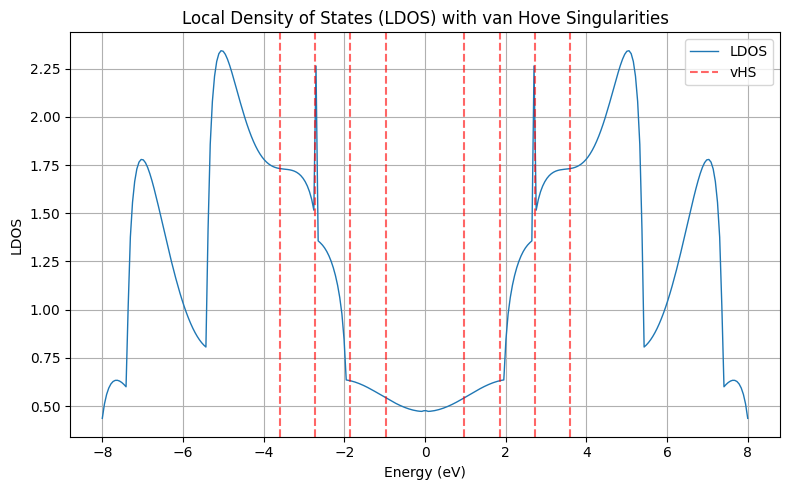

In [6]:
sgf = SanchoRubio((H0_leads, S0_leads), (V_leads, S1_leads), eta=1e-5)
surface_gf_inv = np.array([sgf.get_Ginv(E) for E in energies])
surface_gf = np.linalg.inv(surface_gf_inv)
trace_sgf = np.trace(surface_gf, axis1=1, axis2=2)

ldos = -1 / np.pi * np.imag(trace_sgf)

# --- Known vHS positions (tight-binding, (5,0) CNT, approx. in eV) ---
vhs_positions = [0.97, 1.85, 2.72, 3.60]
vhs_all = vhs_positions + [-e for e in vhs_positions]  # include symmetric negative values

# --- Plot ---
plt.figure(figsize=(8, 5))
plt.plot(energies, ldos, lw=1, label="LDOS")

# Overlay vertical dashed lines for vHS
for ev in vhs_all:
    plt.axvline(ev, color='red', linestyle='--', alpha=0.6, label='vHS' if ev == vhs_all[0] else None)

plt.xlabel("Energy (eV)")
plt.ylabel("LDOS")
plt.title("Local Density of States (LDOS) with van Hove Singularities")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


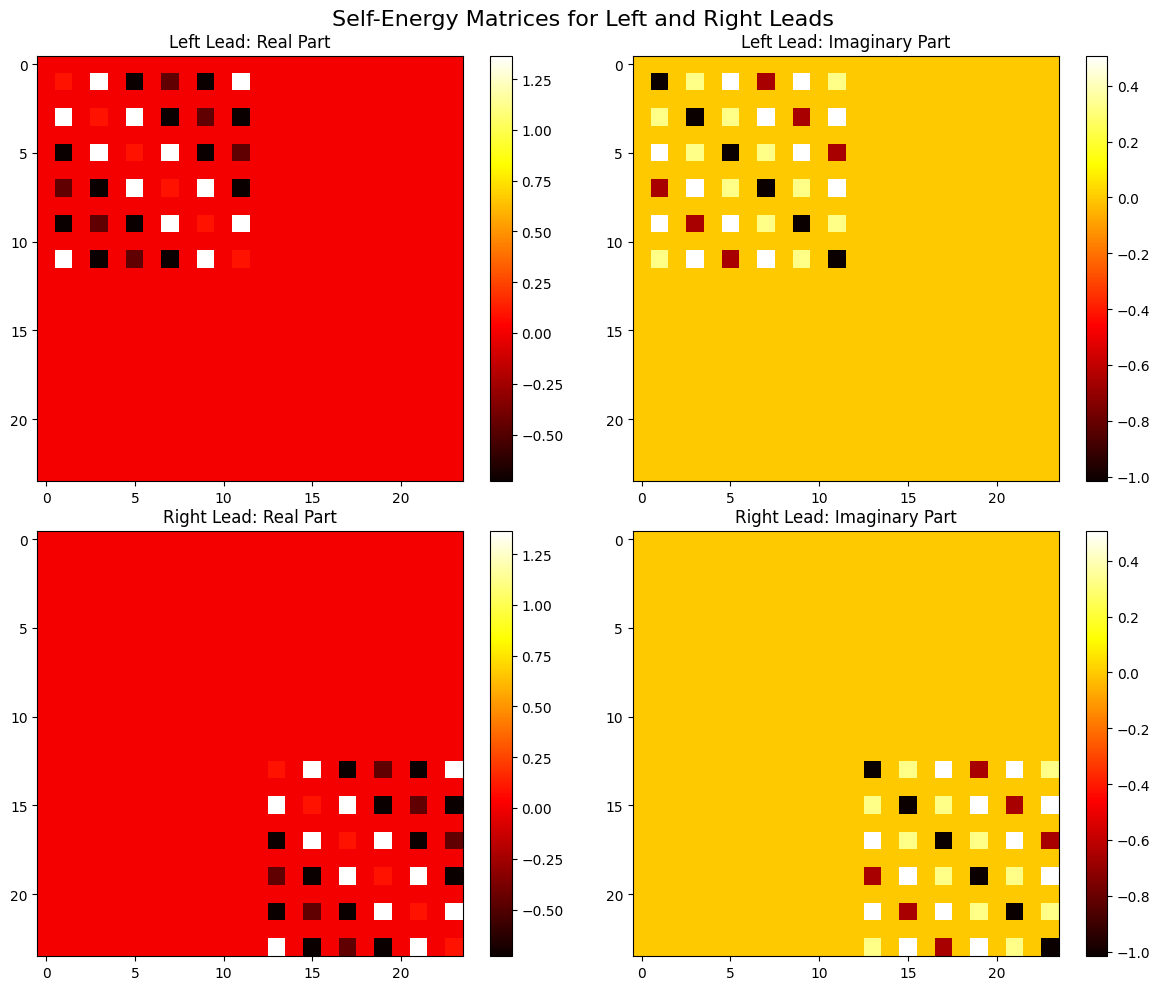

In [7]:
fig, axs = plt.subplots(2, 2, figsize=(12, 10))  # 2 rows, 2 columns

# Left lead (self_energy[0])
im0 = axs[0, 0].imshow(self_energy[0].retarded(-2.0).real, cmap="hot", interpolation="nearest")
axs[0, 0].set_title("Left Lead: Real Part")
fig.colorbar(im0, ax=axs[0, 0])

im1 = axs[0, 1].imshow(self_energy[0].retarded(-2.0).imag, cmap="hot", interpolation="nearest")
axs[0, 1].set_title("Left Lead: Imaginary Part")
fig.colorbar(im1, ax=axs[0, 1])

# Right lead (self_energy[1])
im2 = axs[1, 0].imshow(self_energy[1].retarded(-2.0).real, cmap="hot", interpolation="nearest")
axs[1, 0].set_title("Right Lead: Real Part")
fig.colorbar(im2, ax=axs[1, 0])

im3 = axs[1, 1].imshow(self_energy[1].retarded(-2.0).imag, cmap="hot", interpolation="nearest")
axs[1, 1].set_title("Right Lead: Imaginary Part")
fig.colorbar(im3, ax=axs[1, 1])

# Improve layout
fig.suptitle("Self-Energy Matrices for Left and Right Leads", fontsize=16)
plt.tight_layout()
plt.show()


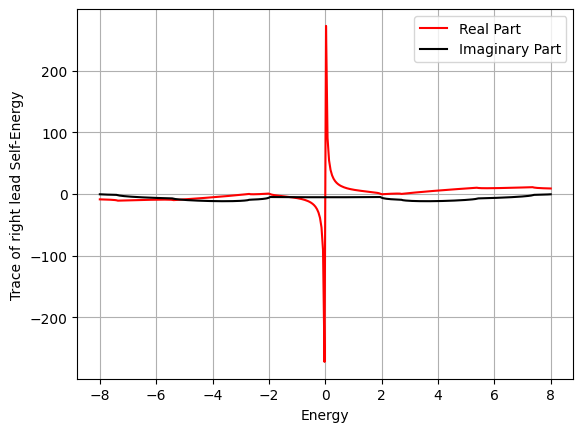

In [8]:
sigma_trace = []
for E in energies:
    sigma = self_energy[1].retarded(E)
    trace_sigma = np.trace(sigma)
    sigma_trace.append(trace_sigma)
plt.plot(energies, np.real(sigma_trace), label="Real Part",color="red")
plt.plot(energies, np.imag(sigma_trace), label="Imaginary Part",color="black")
plt.xlabel("Energy")
plt.ylabel("Trace of right lead Self-Energy")
plt.legend()
plt.grid()

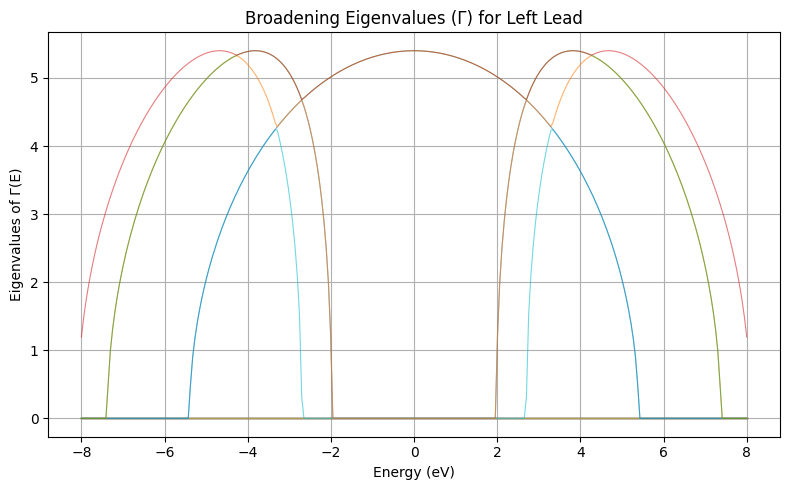

In [9]:
plot_gamma_eigenvalues(self_energy[0], energies, label="Left Lead",log=False)

If we have N atoms in the leads, the leads self energy will be an N X N matrix and therefore, gamma will also be N X N. This means we obtain N eigenvalues of gamma. The number of non-zero eigenvalues at each energy correspond to the number of modes or open channels available in the leads for transport.

In [10]:
threshold = 1e-1
counts = [(np.linalg.eigvalsh(1j * (self_energy[0].retarded(E) -
                                     self_energy[0].retarded(E).T.conj())) > threshold).sum() for E in energies]


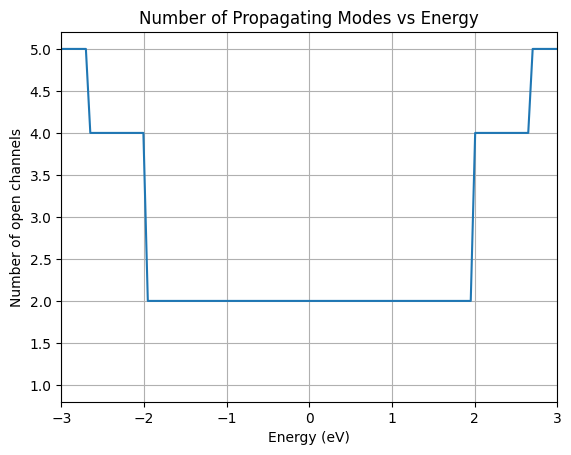

In [11]:
plt.plot(energies, counts)
plt.title("Number of Propagating Modes vs Energy")
plt.xlabel("Energy (eV)")
plt.ylabel("Number of open channels")
plt.xlim(-3, 3)
plt.grid()
plt.show()

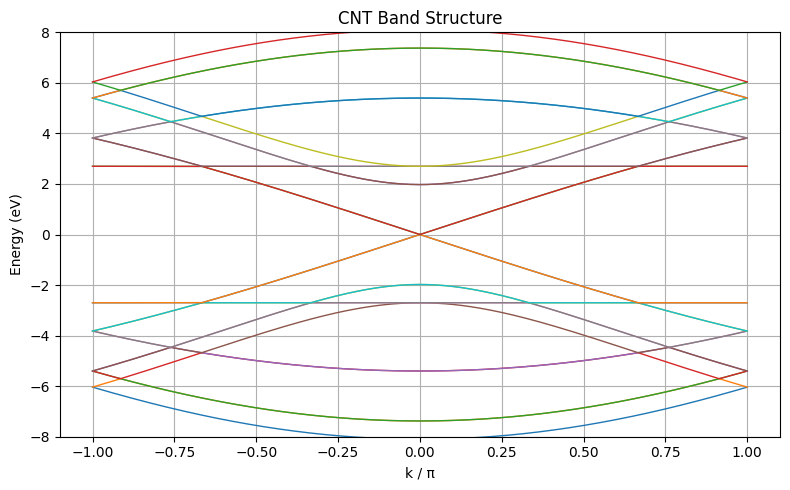

In [12]:

plot_band_structure(H0_leads, V_leads, nk=300, energy_window=(-8, 8), title="CNT Band Structure")


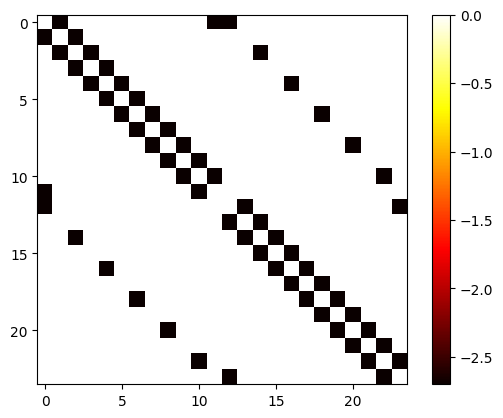

In [18]:
plt.imshow(H0_leads, cmap="hot", interpolation="nearest")
plt.colorbar()

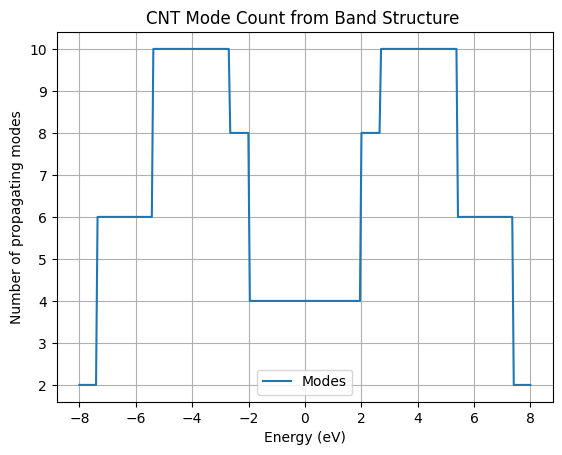

In [13]:

mode_counts = compute_mode_count_from_bandstructure(H0_leads, V_leads, energies)

plt.plot(energies, mode_counts, label="Modes")
plt.xlabel("Energy (eV)")
plt.ylabel("Number of propagating modes")
plt.title("CNT Mode Count from Band Structure ")
plt.grid()
plt.legend()
plt.show()

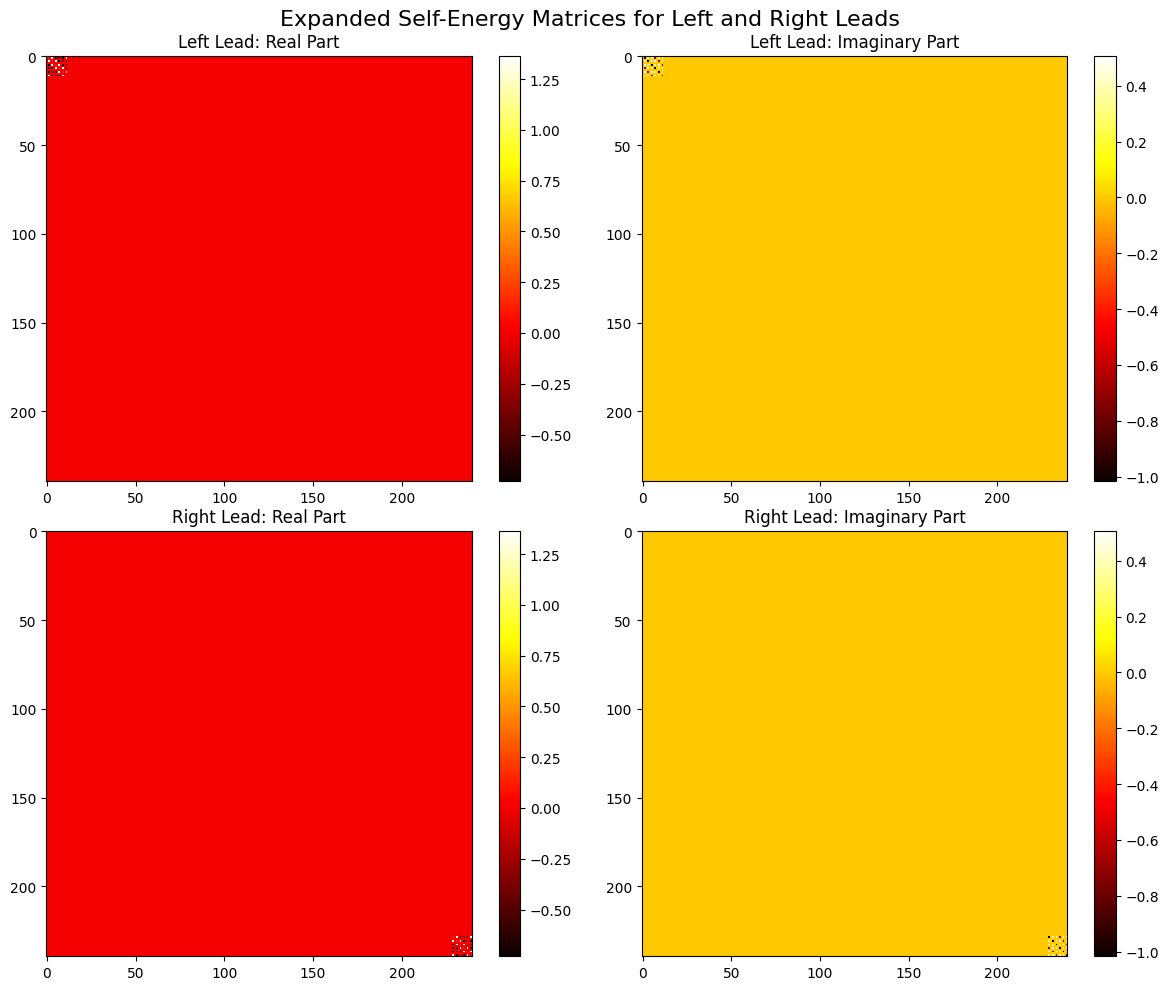

In [14]:
# expand dimension of lead self energy to dimension of scattering region
expand_coupling(self_energy[0], len(H_device[0]))
expand_coupling(self_energy[1], len(H_device[0]), id='right')
fig, axs = plt.subplots(2, 2, figsize=(12, 10))  # 2 rows, 2 columns

# Left lead (self_energy[0])
im0 = axs[0, 0].imshow(self_energy[0].retarded(-2.0).real, cmap="hot", interpolation="nearest")
axs[0, 0].set_title("Left Lead: Real Part")
fig.colorbar(im0, ax=axs[0, 0])

im1 = axs[0, 1].imshow(self_energy[0].retarded(-2.0).imag, cmap="hot", interpolation="nearest")
axs[0, 1].set_title("Left Lead: Imaginary Part")
fig.colorbar(im1, ax=axs[0, 1])

# Right lead (self_energy[1])
im2 = axs[1, 0].imshow(self_energy[1].retarded(-2.0).real, cmap="hot", interpolation="nearest")
axs[1, 0].set_title("Right Lead: Real Part")
fig.colorbar(im2, ax=axs[1, 0])

im3 = axs[1, 1].imshow(self_energy[1].retarded(-2.0).imag, cmap="hot", interpolation="nearest")
axs[1, 1].set_title("Right Lead: Imaginary Part")
fig.colorbar(im3, ax=axs[1, 1])

# Improve layout
fig.suptitle("Expanded Self-Energy Matrices for Left and Right Leads", fontsize=16)
plt.tight_layout()
plt.show()


In [15]:
eta = 1e-5

# slice(None) means that we've already expanded the leads to the scattering region
gf = GreenFunction(H_device, S_device, selfenergies=[(slice(None),self_energy[0]),(slice(None),self_energy[1])], eta=eta)


In [16]:
energies = np.linspace(-3, 3, 100)
gd = GridDesc(energies, 1)
T = np.empty(gd.energies.size)

for e, energy in enumerate(gd.energies):
    T[e] = gf.get_transmission(energy, ferretti=False)

T = gd.gather_energies(T)

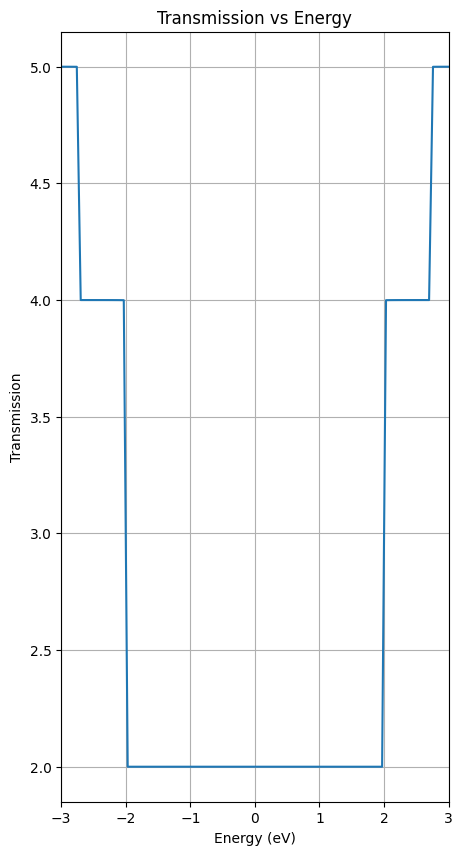

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(energies, T)
plt.xlabel("Energy (eV)")
plt.ylabel("Transmission")
plt.title("Transmission vs Energy")
plt.xlim(-3, 3)
# plt.ylim(0, 1)
plt.grid()
plt.show()


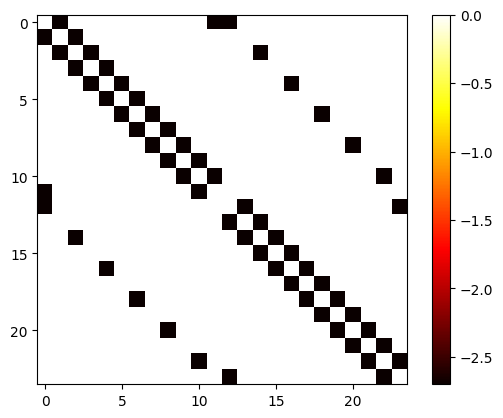

In [8]:
plt.imshow(H0_leads, cmap='hot', interpolation='nearest')
plt.colorbar()
